In [1]:
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.2.2")
easyinstall("gymnasium")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")

try:
  import bbrl
except ImportError:
  !pip install git+https://github.com/osigaud/bbrl.git
  import bbrl

import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import bbrl_gymnasium
from omegaconf import OmegaConf, DictConfig

from bbrl.workspace import Workspace
from bbrl.agents.agent import Agent
from bbrl.agents import Agents, TemporalAgent
from bbrl.agents.gyma import AutoResetGymAgent, NoAutoResetGymAgent

[easypip] Installing bbrl_gymnasium>=0.2.0


In [2]:
################################################################################
################################################################################
##                                  ARS AGENT                                 ##
################################################################################
################################################################################
class ARSAgent(Agent):
    def __init__(self, gym_env, cfg, M):
        """
        Initialize the ARS (Augmented Random Search) agent.

        Args:
            cfg (DictConfig): Configuration for the agent.
            M (torch.tensor): Policy weights.
        """
        super().__init__()
        self.gym_env = gym_env
        self.N = cfg.algorithm.N
        self.M = torch.tensor(M, dtype=torch.float32)
        self.nu = cfg.algorithm.nu
        self.b = cfg.algorithm.b
        self.alpha = cfg.algorithm.alpha
        self.epsilon = cfg.algorithm.epsilon
        self.sigma = torch.eye(M.shape[1])
        self.mu = torch.zeros(M.shape[1])
        self.delta = torch.zeros_like(self.M)

    def forward(self, t, **kwargs):
        """
        Forward pass of the ARS agent.

        Args:
            t (int): Time step.
            **kwargs: Additional arguments.
        """
        raise NotImplementedError("forward must be implemented in subclasses.")

    def set_delta(self, delta):
        """
        Set the perturbation vector.

        Args:
            delta (torch.tensor): Perturbation vector.
        """
        self.delta = torch.tensor(delta, dtype=torch.float32)

    def reset_delta(self):
        """Reset the perturbation vector."""
        self.delta = torch.zeros_like(self.M)

    def update_policy(self, deltas, states_encountered, rewards_plus, rewards_minus):
        """
        Update the policy weights.

        Args:
            deltas (list): List of perturbation vectors.
            states_encountered (list): List of encountered states.
            rewards_plus (list): Rewards obtained with positive perturbations.
            rewards_minus (list): Rewards obtained with negative perturbations.
        """
        rewards_plus_list = np.array([tensor.item() for tensor in rewards_plus])
        rewards_minus_list = np.array([tensor.item() for tensor in rewards_minus])
        # print(f"{deltas=}")
        # print(f"{rewards_plus_list=}")
        # print(f"{rewards_minus_list=}")
        scores = list(zip(deltas, rewards_plus_list, rewards_minus_list))
        # print(f"{scores=}")
        scores.sort(key=lambda x: max(x[1], x[2]), reverse=True)
        # print(f"{scores=}")
        top_scores = scores[:self.b]
        # print(f"{top_scores=}")

        # Update policy weights using the top b perturbations
        update_step = np.zeros_like(self.M.numpy())
        sigma_rewards = np.std([r for _, r_plus, r_minus in top_scores for r in (r_plus, r_minus)]) + self.epsilon
        for delta, reward_plus, reward_minus in top_scores:
            update_step += (reward_plus - reward_minus) * np.array(delta)

        # Apply update to policy weights
        self.M += (self.alpha / (self.b * sigma_rewards)) * torch.from_numpy(update_step)
        # print(self.M)
        # print()


################################################################################
#                                 ARS V1 AGENT                                 #
################################################################################
class ARS_V1_Agent(ARSAgent):
    def forward(self, t, **kwargs):
        """
        Forward pass of the ARS agent.

        Args:
            t (int): Time step.
            **kwargs: Additional arguments.
        """
        obs = self.get(("obs", t))
        action = torch.mm(self.M + self.nu * self.delta, obs.unsqueeze(1)).squeeze()

        if isinstance(self.gym_env.action_space, gym.spaces.Discrete):
            action_list = [tensor.item() for tensor in action]
            try:
                action = 1 if action_list > 0 else 0
            except ValueError as ve:
                action = np.argmax(action_list)
            except TypeError as te:
              normalized_actions = np.clip(action_list, -1, 1)
              action = 1 if normalized_actions[0] > 0 else 0

        else:
            try:
                action = np.clip(action, self.gym_env.action_space.low, self.gym_env.action_space.high)
            except ValueError as ve:
                action = np.clip(np.argmax(action), self.gym_env.action_space.low, self.gym_env.action_space.high)

        action = torch.tensor(action, dtype=torch.float32)
        action = action.view(-1)
        action = action.to('cpu')
        action = action.float()
        self.set(("action", t), action)


################################################################################
#                                 ARS V2 AGENT                                 #
################################################################################
class ARS_V2_Agent(ARSAgent):
    def forward(self, t, **kwargs):
        """
        Forward pass of the ARS agent.

        Args:
            t (int): Time step.
            **kwargs: Additional arguments.
        """
        obs = self.get(("obs", t))
        M_plus_delta = self.M + self.nu * self.delta
        sigma_sqrt_inv = torch.linalg.inv(torch.sqrt(self.sigma))
        product = torch.mm(M_plus_delta, sigma_sqrt_inv)
        diff = obs - self.mu
        action = torch.mm(product, diff.unsqueeze(1)).squeeze()

        if isinstance(self.gym_env.action_space, gym.spaces.Discrete):
            action_list = [tensor.item() for tensor in action]
            try:
                action = 1 if action_list > 0 else 0
            except ValueError as ve:
                action = np.argmax(action_list)
            except TypeError as te:
              normalized_actions = np.clip(action_list, -1, 1)
              action = 1 if normalized_actions[0] > 0 else 0

        else:
            try:
                action = np.clip(action, self.gym_env.action_space.low, self.gym_env.action_space.high)
            except ValueError as ve:
                action = np.clip(np.argmax(action), self.gym_env.action_space.low, self.gym_env.action_space.high)

        action = torch.tensor(action, dtype=torch.float32)
        action = action.view(-1)
        action = action.to('cpu')
        action = action.float()
        self.set(("action", t), action)


    def update_policy(self, deltas, states_encountered, rewards_plus, rewards_minus):
        """
        Update the policy weights for ARS version 2.

        Args:
            deltas (list): List of perturbation vectors.
            states_encountered (list): List of encountered states.
            rewards_plus (list): Rewards obtained with positive perturbations.
            rewards_minus (list): Rewards obtained with negative perturbations.
        """
        super().update_policy(deltas, states_encountered, rewards_plus, rewards_minus)

        # Version-specific update
        states_tensor = torch.tensor(states_encountered)
        self.mu = torch.mean(states_tensor, dim=0)
        states_tensor_transpose = torch.transpose(states_tensor, 0, 1)
        sigma = torch.matmul(states_tensor_transpose, states_tensor) / states_tensor.size(0)
        self.sigma += self.epsilon * torch.eye(sigma.size(0))



################################################################################
################################################################################



################################################################################
################################################################################
##                                  ENV AGENT                                 ##
################################################################################
################################################################################
class EnvAgent(Agent):
    def __init__(self, cfg):
        """
        Initialize the environment agent.

        Args:
            cfg (DictConfig): Configuration for the agent.
        """
        super().__init__()
        self.gym_env = gym.make(cfg.gym_env.env_name)
        self.states_encountered = []


    def forward(self, t, **kwargs):
        """
        Forward pass of the environment agent.

        Args:
            t (int): Time step.
            **kwargs: Additional arguments.
        """
        if t==0:
            obs = self.gym_env.reset()[0]
            self.set(("obs", t), torch.tensor(obs))
        else:
            action = self.get(("action", t-1))
            # print(f"{t=}")
            # print(f"{action=}")
            if isinstance(self.gym_env.action_space, gym.spaces.Discrete):
                obs, reward, terminated, truncated, _ = self.gym_env.step(int(action.item()))
            else:
                obs, reward, terminated, truncated, _ = self.gym_env.step(action)
            # print(f"{obs=}")
            # print(f"{reward=}")
            # print()
            self.set(("obs", t), torch.tensor(obs))
            # theta = np.arctan2(obs[1], obs[0])
            # plot_pendulum(theta)
            if isinstance(self.gym_env.action_space, gym.spaces.Discrete):
                reward = torch.tensor(reward, dtype=torch.float32)
                reward = action.view(-1)
                reward = action.to('cpu')
                reward = action.float()
                self.set(("reward", t), reward)
            else:
                self.set(("reward", t), reward.unsqueeze(0).clone().detach())
        self.states_encountered.append(obs)


    def get_obs_and_actions_sizes(self):
        """Get observation and action sizes of the environment."""
        observation_dim = self.gym_env.observation_space.shape[0]
        if isinstance(self.gym_env.action_space, gym.spaces.Discrete):
            action_dim = self.gym_env.action_space.n
        else:
            action_dim = self.gym_env.action_space.shape[0]
        return observation_dim, action_dim



################################################################################
################################################################################


def plot_pendulum(theta):
    x = np.sin(theta)
    y = -np.cos(theta)

    plt.figure(figsize=(5, 5))
    plt.plot([0, x], [0, y], color='black')
    plt.scatter([x], [y], s=100, color='blue', zorder=5)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axvline(x=0, color='grey', lw=1, zorder=0)
    plt.axhline(y=0, color='grey', lw=1, zorder=0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pendulum State')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


################################################################################
################################################################################



# Create the ARS Agent
def create_ARS_agent(cfg, env_agent):
    observation_dim, action_dim = env_agent.get_obs_and_actions_sizes()
    M = np.zeros((action_dim, observation_dim))

    if cfg.algorithm.v2:
        ars_agent = ARS_V2_Agent(env_agent.gym_env, cfg, M=M)
    else:
        ars_agent = ARS_V1_Agent(env_agent.gym_env, cfg, M=M)

    return ars_agent


def run_ars(cfg: DictConfig):
    env_agent = EnvAgent(cfg)
    H = env_agent.gym_env.spec.max_episode_steps

    ars_agent = create_ARS_agent(cfg, env_agent)

    composed_agent = Agents(env_agent, ars_agent)
    t_agent = TemporalAgent(composed_agent)
    workspace = Workspace()

    best_reward = -np.inf
    rewards_plus_logs = []
    rewards_minus_logs = []
    best_rewards_log = []
    std_rewards_log = []
    episode_rewards = []

    for episode in range(cfg.algorithm.num_episodes):
        deltas = np.random.randn(ars_agent.N, *ars_agent.M.shape)
        rewards_plus = []     # To store rewards when adding perturbations
        rewards_minus = []    # To store rewards when subtracting perturbations
        states_encountered = []

        for delta in deltas:
            ars_agent.set_delta(delta)
            workspace.clear()
            env_agent.gym_env.reset()
            t_agent(workspace, t=0, n_steps=H)
            rewards_plus.append(workspace['reward'].sum())
            states_encountered.extend(env_agent.states_encountered)

            ars_agent.set_delta(-delta)
            workspace.clear()
            env_agent.gym_env.reset()
            t_agent(workspace, t=0, n_steps=H)
            rewards_minus.append(workspace['reward'].sum())
            states_encountered.extend(env_agent.states_encountered)

            ars_agent.reset_delta()

        # Calculate statistics for logging
        average_reward_plus = np.mean(rewards_plus)
        average_reward_minus = np.mean(rewards_minus)
        std_reward = np.std(rewards_plus + rewards_minus)
        episode_reward = (average_reward_plus + average_reward_minus) / 2
        episode_best_reward = max(max(rewards_plus), max(rewards_minus))

        # Update logs
        rewards_plus_logs.append(average_reward_plus)
        rewards_minus_logs.append(average_reward_minus)
        std_rewards_log.append(std_reward)
        episode_rewards.append(episode_reward)
        best_rewards_log.append(episode_best_reward if episode_best_reward > best_reward else best_reward)

        # Optional verbose logging
        if cfg.verbose:
            print(f"Episode {episode+1}:")
            print(f"Average Reward (Positive Perturbations): {average_reward_plus}")
            print(f"Average Reward (Negative Perturbations): {average_reward_minus}")
            print(f"Standard Deviation of Rewards: {std_reward}")
            print(f"Maximum Reward (Current Episode): {episode_best_reward}")
            # Update best reward
            if episode_best_reward > best_reward:
                best_reward = episode_best_reward
                print(f"New Best Reward: {best_reward}")
            print()

        ars_agent.update_policy(deltas, states_encountered, rewards_plus, rewards_minus)

    env_agent.gym_env.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rewards_plus_logs, label='Average Reward Plus')
    plt.plot(rewards_minus_logs, label='Average Reward Minus')
    plt.plot(best_rewards_log, label='Best Reward', color='green')
    plt.fill_between(range(cfg.algorithm.num_episodes), np.array(rewards_plus_logs) - np.array(std_rewards_log), np.array(rewards_plus_logs) + np.array(std_rewards_log), color='blue', alpha=0.1)
    plt.fill_between(range(cfg.algorithm.num_episodes), np.array(rewards_minus_logs) - np.array(std_rewards_log), np.array(rewards_minus_logs) + np.array(std_rewards_log), color='orange', alpha=0.1)
    plt.title('ARS Performance over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
cfg_dict = {
    "algorithm": {
        "N": 60,
        "nu": 0.03,
        "b": 15,
        "alpha": 0.01,
        "epsilon": 1e-6,
        "num_episodes": 100,
        "v2": False,
    },
    "gym_env": {
        "env_name": "Pendulum-v1",
    },
    "verbose" : True
}

cfg = OmegaConf.create(cfg_dict)

<ipython-input-2-93508dd46a45>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


Episode 1:
Average Reward (Positive Perturbations): -1226.157470703125
Average Reward (Negative Perturbations): -1228.6138916015625
Standard Deviation of Rewards: 290.6954345703125
Maximum Reward (Current Episode): -594.4855346679688
New Best Reward: -594.4855346679688

Episode 2:
Average Reward (Positive Perturbations): -1258.3953857421875
Average Reward (Negative Perturbations): -1275.0133056640625
Standard Deviation of Rewards: 314.1363830566406
Maximum Reward (Current Episode): -626.5303955078125

Episode 3:
Average Reward (Positive Perturbations): -1351.5926513671875
Average Reward (Negative Perturbations): -1272.2132568359375
Standard Deviation of Rewards: 299.8078918457031
Maximum Reward (Current Episode): -761.7200927734375

Episode 4:
Average Reward (Positive Perturbations): -1245.263671875
Average Reward (Negative Perturbations): -1304.50830078125
Standard Deviation of Rewards: 277.0687255859375
Maximum Reward (Current Episode): -830.1361694335938

Episode 5:
Average Reward (

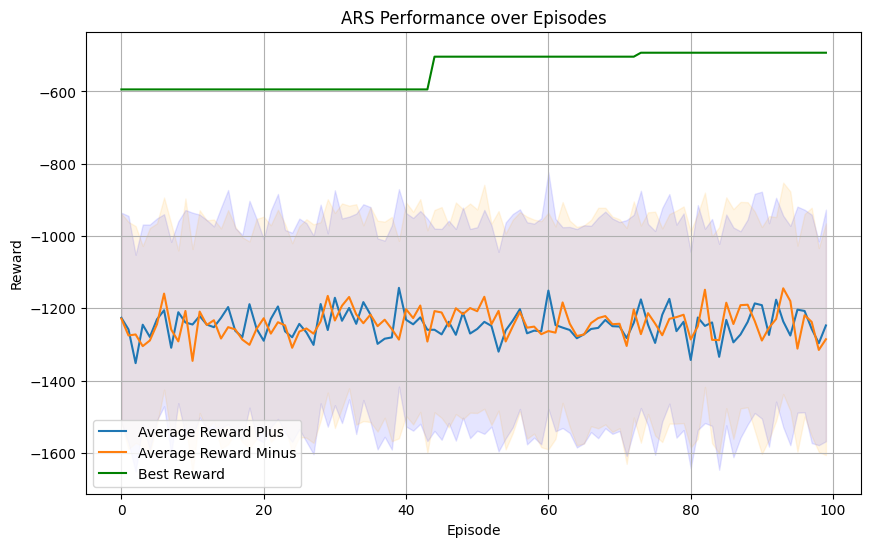

In [4]:
cfg.algorithm.v2 = False
cfg.verbose = True

run_ars(cfg)

In [ ]:
cfg.algorithm.v2 = True
cfg.verbose = False

run_ars(cfg)